# Imports

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from itertools import combinations
from statannotations.Annotator import Annotator

from lifelines.utils import k_fold_cross_validation
from lifelines import CoxPHFitter

from scipy import stats
from scipy.stats import mannwhitneyu

%matplotlib inline

In [2]:
sns.set_theme(context='notebook', style='white', 
              font = 'arial', font_scale = 1)

In [3]:
def label_plot_for_PE_GA(ax):
    plt.title("Mutational Burden", y=1.06)
    ax.set_ylabel("Genomic Instability")
    ax.set_xlabel("Group", labelpad=20)

def label_plot_for_hyp(ax):
    plt.title("Hypoxia Score", y=1.06)
    ax.set_ylabel("Hypoxia Score")
    ax.set_xlabel("Group", labelpad=20)
    
def get_log_ax(orient="v"):
    if orient == "v":
        figsize = (12, 6)
        set_scale = "set_yscale"
    else:
        figsize = (10, 8)
        set_scale = "set_xscale"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    fig.patch.set_alpha(1)
    #getattr(ax, set_scale)("log")
    return ax

## Discovery data import

In [4]:
samples =  pd.read_csv("inputs_new/Disc_cohort_SampleID.csv")["SampleID"]
maf = pd.read_csv("inputs_new/disc_20250721_maftools.maf", sep = "\t")

maf = maf[maf['Tumor_Sample_Barcode'].isin(samples)]
maf['vaf'] = maf['t_alt_count']/(maf['t_alt_count']+maf['t_ref_count'])
maf

,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Variant_Classification,Variant_Type,...,t_AD,n_AD,t_DP,n_DP,t_GQ,n_GQ,t_PL,n_PL,cohort,vaf
0,SH3D21,79729,.,GRCh38,chr1,36320626,36320627,+,Frame_Shift_Ins,INS,...,"45,17",NaN,64,NaN,99,NaN,"359,0,1215",NaN,disc,0.274194
1,HSD3B2,3284,.,GRCh38,chr1,119422454,119422454,+,Missense_Mutation,SNP,...,"2,58",NaN,60,NaN,91,NaN,"2520,91,0",NaN,disc,0.966667
2,SH3BP5,9467,.,GRCh38,chr3,15256280,15256280,+,Missense_Mutation,SNP,...,"124,186",NaN,310,NaN,99,NaN,"4749,0,3158",NaN,disc,0.600000
3,GOLGB1,2804,.,GRCh38,chr3,121691766,121691766,+,Missense_Mutation,SNP,...,"53,68",NaN,121,NaN,99,NaN,"1784,0,1383",NaN,disc,0.561983
4,SLCO2A1,6578,.,GRCh38,chr3,134029726,134029726,+,Missense_Mutation,SNP,...,"34,38",NaN,72,NaN,99,NaN,"1188,0,1033",NaN,disc,0.527778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5623,TUBA1C,84790,.,GRCh38,chr12,49265184,49265185,+,Frame_Shift_Ins,INS,...,"3,117",NaN,120,NaN,99,NaN,"5121,226,0",NaN,disc,0.975000
5624,TMEM100,55273,.,GRCh38,chr17,55720774,55720775,+,Frame_Shift_Ins,INS,...,"46,21",NaN,67,NaN,99,NaN,"398,0,1198",NaN,disc,0.313433
5625,PSG4,5672,.,GRCh38,chr19,43194588,43194588,+,Missense_Mutation,SNP,...,"350,234",NaN,584,NaN,99,NaN,"5225,0,11621",NaN,disc,0.400685
5626,FBLN1,2192,.,GRCh38,chr22,45542276,45542276,+,Missense_Mutation,SNP,...,"24,38",NaN,62,NaN,99,NaN,"1443,0,627",NaN,disc,0.612903


In [5]:
print(len(maf["Tumor_Sample_Barcode"].value_counts()))
maf['vaf'].describe()

112


count    4131.000000
mean        0.504893
std         0.156062
min         0.179191
25%         0.426230
50%         0.497110
75%         0.563380
max         0.999487
Name: vaf, dtype: float64

In [6]:
vaf_df = pd.DataFrame(maf['Tumor_Sample_Barcode'].value_counts())
vaf_df.rename(columns={'count': 'vaf_filtered_mut_count'}, inplace=True)

print(vaf_df.shape)
vaf_df['vaf_filtered_mut_count'].describe()

(112, 1)


count    112.000000
mean      36.883929
std       12.280319
min       14.000000
25%       28.000000
50%       35.500000
75%       42.000000
max       74.000000
Name: vaf_filtered_mut_count, dtype: float64

In [7]:
df = pd.read_csv("./inputs_new/meta_obreg_peadj_clin.csv",index_col=0)
print(df.shape)
df.head()

(201, 3592)


,plac_num,demo_study_id_1,demo_ethnicity,demo_race___1,demo_race___2,demo_race___3,demo_race___4,demo_race___7,demo_race___8,demo_race___9,...,eTMB,GA,adj_Dx,Groups,Pathology_category,Groups_for_PE_siPE,plac_path_n.y,Fetal_Sex,plac_num.y,variant_cohort
plac_id,,,,,,,,,,,,,,,,,,,,,
P1_1154,1154,LD0569,2.0,1,0,0,0,0,0,0,...,0.028790,36.0,SPET,preeclampsia,Normal,PE_siPE,P13-217,2.0,1154.0,validation
P1_1651,1651,LD0958,2.0,0,0,0,1,0,0,0,...,0.034631,35.2,SPET,preeclampsia,MVM with FVM,PE_siPE,P14-673,1.0,1651.0,validation
P1_1689,1689,LD0951,2.0,0,0,0,1,0,0,0,...,0.030978,34.5,SPET,preeclampsia,pureMVM,PE_siPE,P15-58,1.0,1689.0,validation
P1_1748,1748,LD1017,2.0,0,1,0,0,0,0,0,...,0.055962,37.1,SPET,preeclampsia,FVM,PE_siPE,P15-188,2.0,1748.0,validation
P1_1973,1973,FC0258,2.0,0,0,0,1,0,0,0,...,0.031903,37.1,SPET,preeclampsia,pureMVM,PE_siPE,P16-32,2.0,1973.0,validation


In [8]:
df['Path_MVM_binary'] = (df['asw_subclass_pure_mvm'] + df['asw_subclass_mvm_fvm'] + 
                         df['asw_subclass_mvm_vue'])
df['Path_FVM_binary'] = (df['asw_subclass_pure_fvm'] + df['asw_subclass_mvm_fvm'])
df['SampleID'] = 'Sample' + df.index.astype(str)
df['SGA_binary'] = df['calculated_iugr.x'].map({0.0: 0, 1.0: 1})


In [9]:
disc_merged_df = pd.merge(df, vaf_df, left_on = 'SampleID', right_on = 'Tumor_Sample_Barcode')
disc_merged_df['eTMB_VAF_filtered'] = disc_merged_df['vaf_filtered_mut_count']*100/disc_merged_df['Number_of_bases_per106.megabase.']
disc_merged_df['eTMB'] = disc_merged_df['eTMB_VAF_filtered']
disc_merged_df.shape

(112, 3597)

In [10]:
# disc_merged_df.to_csv("output_20250721/Disc_cohort_metadata_vaf_20250721.csv")

In [11]:
df = disc_merged_df
df['variant_cohort'].value_counts()

variant_cohort
discovery    112
Name: count, dtype: int64

## Validation cohort

In [12]:
samples =  pd.read_csv("inputs_new/RNAseq_validation_cohort_49samples_metadata_fullclinical_final.csv")
samples['SampleID'] = 'Sample' + samples["X"]

maf = pd.read_csv("inputs_new/val_20250721_maftools.maf", sep = "\t")

maf = maf[maf['Tumor_Sample_Barcode'].isin(samples["SampleID"])]
maf['vaf'] = maf['t_alt_count']/(maf['t_alt_count']+maf['t_ref_count'])
maf

,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Variant_Classification,Variant_Type,...,t_AD,n_AD,t_DP,n_DP,t_GQ,n_GQ,t_PL,n_PL,cohort,vaf
0,PRDM2,7799,.,GRCh38,chr1,13778741,13778741,+,Missense_Mutation,SNP,...,"25,40",NaN,65,NaN,99,NaN,"1041,0,679",NaN,val,0.615385
1,IDH1,3417,.,GRCh38,chr2,208251493,208251493,+,Missense_Mutation,SNP,...,"26,29",NaN,55,NaN,99,NaN,"900,0,725",NaN,val,0.527273
2,PSMD1,5707,.,GRCh38,chr2,231083717,231083717,+,Missense_Mutation,SNP,...,"38,17",NaN,55,NaN,99,NaN,"391,0,1173",NaN,val,0.309091
3,MAST4,375449,.,GRCh38,chr5,67162743,67162743,+,Missense_Mutation,SNP,...,"96,90",NaN,186,NaN,99,NaN,"2335,0,2601",NaN,val,0.483871
4,VCAN,1462,.,GRCh38,chr5,83538243,83538243,+,Missense_Mutation,SNP,...,"58,46",NaN,104,NaN,99,NaN,"1290,0,1850",NaN,val,0.442308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1879,MT-ND5,4540,.,GRCh38,chrM,12346,12346,+,Missense_Mutation,SNP,...,"3,326",NaN,329,NaN,99,NaN,"13087,0",NaN,val,0.990881
1880,UBXN4,23190,.,GRCh38,chr2,135780349,135780349,+,Missense_Mutation,SNP,...,"20,35",NaN,62,NaN,99,NaN,"949,0,534",NaN,val,0.636364
1881,CYREN,78996,.,GRCh38,chr7,135167796,135167796,+,Missense_Mutation,SNP,...,"34,22",NaN,56,NaN,99,NaN,"682,0,1152",NaN,val,0.392857
1882,TLN1,7094,.,GRCh38,chr9,35714339,35714339,+,Missense_Mutation,SNP,...,"41,37",NaN,78,NaN,99,NaN,"1276,0,1282",NaN,val,0.474359


In [13]:
print(len(maf["Tumor_Sample_Barcode"].value_counts()))
maf['vaf'].describe()

49


count    1328.000000
mean        0.525131
std         0.143672
min         0.194805
25%         0.445816
50%         0.506370
75%         0.565815
max         0.999732
Name: vaf, dtype: float64

In [14]:
vaf_df = pd.DataFrame(maf['Tumor_Sample_Barcode'].value_counts())
vaf_df.rename(columns={'count': 'vaf_filtered_mut_count'}, inplace=True)

print(vaf_df.shape)
vaf_df['vaf_filtered_mut_count'].describe()

(49, 1)


count    49.000000
mean     27.102041
std       9.312279
min      13.000000
25%      20.000000
50%      25.000000
75%      32.000000
max      56.000000
Name: vaf_filtered_mut_count, dtype: float64

In [15]:
df = pd.read_csv("./inputs_new/meta_obreg_peadj_clin.csv",index_col=0)
print(df.shape)
df.head()

(201, 3592)


,plac_num,demo_study_id_1,demo_ethnicity,demo_race___1,demo_race___2,demo_race___3,demo_race___4,demo_race___7,demo_race___8,demo_race___9,...,eTMB,GA,adj_Dx,Groups,Pathology_category,Groups_for_PE_siPE,plac_path_n.y,Fetal_Sex,plac_num.y,variant_cohort
plac_id,,,,,,,,,,,,,,,,,,,,,
P1_1154,1154,LD0569,2.0,1,0,0,0,0,0,0,...,0.028790,36.0,SPET,preeclampsia,Normal,PE_siPE,P13-217,2.0,1154.0,validation
P1_1651,1651,LD0958,2.0,0,0,0,1,0,0,0,...,0.034631,35.2,SPET,preeclampsia,MVM with FVM,PE_siPE,P14-673,1.0,1651.0,validation
P1_1689,1689,LD0951,2.0,0,0,0,1,0,0,0,...,0.030978,34.5,SPET,preeclampsia,pureMVM,PE_siPE,P15-58,1.0,1689.0,validation
P1_1748,1748,LD1017,2.0,0,1,0,0,0,0,0,...,0.055962,37.1,SPET,preeclampsia,FVM,PE_siPE,P15-188,2.0,1748.0,validation
P1_1973,1973,FC0258,2.0,0,0,0,1,0,0,0,...,0.031903,37.1,SPET,preeclampsia,pureMVM,PE_siPE,P16-32,2.0,1973.0,validation


In [16]:
df['Path_MVM_binary'] = (df['asw_subclass_pure_mvm'] + df['asw_subclass_mvm_fvm'] + 
                         df['asw_subclass_mvm_vue'])
df['Path_FVM_binary'] = (df['asw_subclass_pure_fvm'] + df['asw_subclass_mvm_fvm'])
df['SampleID'] = 'Sample' + df.index.astype(str)

In [17]:
val_merged_df = pd.merge(df, vaf_df, left_on = 'SampleID', right_on = 'Tumor_Sample_Barcode')
val_merged_df['eTMB_VAF_filtered'] = val_merged_df['vaf_filtered_mut_count']*100/val_merged_df['Number_of_bases_per106.megabase.']
val_merged_df['eTMB'] = val_merged_df['eTMB_VAF_filtered']
val_merged_df.shape

(49, 3596)

In [18]:
# val_merged_df.to_csv("output_20250721/Val_cohort_metadata_vaf_20250721.csv")

# Figure and Extended Data Figure 1

## Distributions

In [19]:
df = disc_merged_df
df['variant_cohort'].value_counts()

variant_cohort
discovery    112
Name: count, dtype: int64

In [20]:
# discovery distributions 

print(df['PE_onset_uniform'].value_counts())

PE_onset_uniform
PE_LO        39
Normal_LO    30
Normal_EO    23
PE_EO        20
Name: count, dtype: int64


In [21]:
print(df[df['Path_MVM_binary'] == 1]['PE_binary'].value_counts())
print(df[df['asw_subclass_nonlesion'] == 1]['PE_binary'].value_counts())
print(df[df['asw_subclass_pure_fvm'] == 1]['PE_binary'].value_counts())
print(df[df['asw_subclass_pure_vue'] == 1]['PE_binary'].value_counts())

PE_binary
1.0    28
0.0    10
Name: count, dtype: int64
PE_binary
1.0    20
0.0    14
Name: count, dtype: int64
PE_binary
0.0    23
1.0     6
Name: count, dtype: int64
PE_binary
0.0    6
1.0    5
Name: count, dtype: int64


In [22]:
print(df[df['calculated_iugr.x'] == 0]['PE_binary'].value_counts())
print(df[df['calculated_iugr.x'] == 1]['PE_binary'].value_counts())

PE_binary
0.0    53
1.0    14
Name: count, dtype: int64
PE_binary
1.0    45
Name: count, dtype: int64


## Figure 1A, ED 1B (Demographic plots):

In [23]:
test_df = df

In [24]:
print("No PE Mean:", test_df[test_df['PE_binary'] == 0]['age_delivery.x'].mean())
print("PE Mean:", test_df[test_df['PE_binary'] == 1]['age_delivery.x'].mean())

No PE Mean: 31.41509433962264
PE Mean: 30.847457627118644


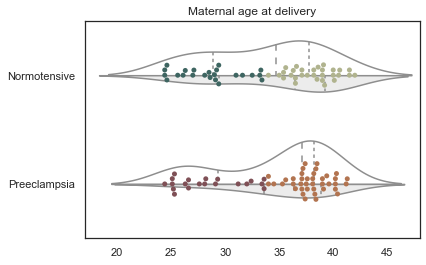

In [25]:
test_df['MatAgeBin'] = np.where((test_df['age_delivery.x']>=35) , 1, 0)
test_df['PE_names'] = np.where((test_df['PE_binary']==0) , "Normotensive", "Preeclampsia")
test_df.sort_values(by='PE_names', ascending=True, inplace=True)

plt.rcParams['text.usetex'] = False

colors1 = ["white", "#ECECEC"]
colors = ['#3e6561', '#b0b38e', '#7f5056','#b27450']

plt.figure()
plot = sns.violinplot(data=test_df, x="GA", y="PE_names", hue="MatAgeBin", fill=True,
                       split=True, scale="count", scale_hue=False, palette=colors1, inner="quartile", 
                      orient="h")
plot = sns.swarmplot(x="GA", y="PE_names", data=test_df, palette=colors, hue="PE_onset_uniform") # color=".2", size = 3.5)

plt.ylabel('')
plt.title('Maternal age at delivery')
plt.legend().remove()
plt.xlim(17, 48)
plt.xlabel('')

plt.savefig("output_final/figure1/Demographics_Placental_Maternal_Age_20250707.pdf", format="pdf", bbox_inches="tight")

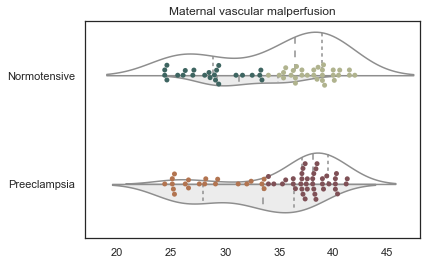

In [26]:
test_df['PE_names'] = np.where((test_df['PE_binary']==0) , "Normotensive", "Preeclampsia")
test_df.sort_values(by='PE_names', ascending=True, inplace=True)

plt.rcParams['text.usetex'] = False

colors1 = ["white", "#ECECEC"]
colors = ['#3e6561', '#b0b38e', '#7f5056','#b27450']

plt.figure()
plot = sns.violinplot(data=test_df, x="GA", y="PE_names", hue="Path_MVM_binary", fill=True,
                       split=True, scale="count", scale_hue=False, palette=colors1, inner="quartile", 
                      orient="h")
plot = sns.swarmplot(x="GA", y="PE_names", data=test_df, palette=colors,hue="PE_onset_uniform") # color=".2", size = 3.5)

plt.xlabel('')
plt.xlim(17, 48)
plt.ylabel('')
plt.title('Maternal vascular malperfusion')
plt.legend().remove()

plt.savefig("output_final/figure1/Demographics_MVM_20250707.pdf", format="pdf", bbox_inches="tight")

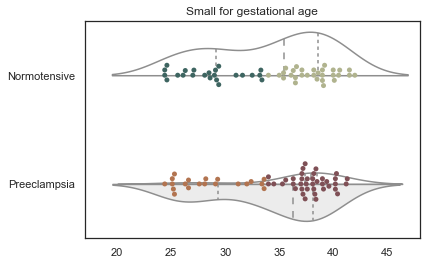

In [27]:
test_df['PE_names'] = np.where((test_df['PE_binary']==0) , "Normotensive", "Preeclampsia")
test_df.sort_values(by='PE_names', ascending=True, inplace=True)

plt.rcParams['text.usetex'] = False

colors1 = ["white", "#ECECEC"]
colors = ['#3e6561', '#b0b38e', '#7f5056','#b27450']

plt.figure()
plot = sns.violinplot(data=test_df, x="GA", y="PE_names", hue="calculated_iugr.x", fill=True,
                       split=True, scale="count", scale_hue=False, palette=colors1, inner="quartile", 
                      orient="h")
plot = sns.swarmplot(x="GA", y="PE_names", data=test_df, palette=colors,hue="PE_onset_uniform") # color=".2", size = 3.5)

plt.xlabel('')
plt.xlim(17, 48)
plt.ylabel('')
plt.title('Small for gestational age')
plt.legend().remove()

plt.savefig("output_final/figure1/Demographics_SGA_20250707.pdf", format="pdf", bbox_inches="tight")

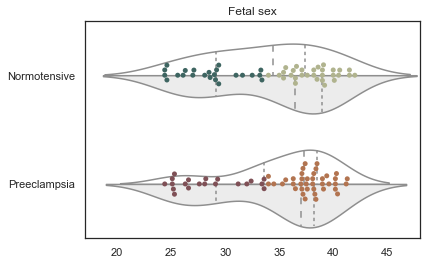

In [28]:
test_df['PE_names'] = np.where((test_df['PE_binary']==0) , "Normotensive", "Preeclampsia")
test_df.sort_values(by='PE_names', ascending=True, inplace=True)

plt.rcParams['text.usetex'] = False

colors1 = ["white", "#ECECEC"]
colors = ['#3e6561', '#b0b38e', '#7f5056','#b27450']

plt.figure()
plot = sns.violinplot(data=test_df, x="GA", y="PE_names", hue="Fetal_sex_binary", fill=True,
                       split=True, scale="count", scale_hue=False, palette=colors1, inner="quartile", 
                      orient="h")
plot = sns.swarmplot(x="GA", y="PE_names", data=test_df, palette=colors,hue="PE_onset_uniform") # color=".2", size = 3.5)

plt.xlabel('')
plt.xlim(17, 48)
plt.ylabel('')
plt.title('Fetal sex')
plt.legend().remove()

plt.savefig("output_final/figure1/Demographics_Fetal_sex_binary_20250707.pdf", format="pdf", bbox_inches="tight")

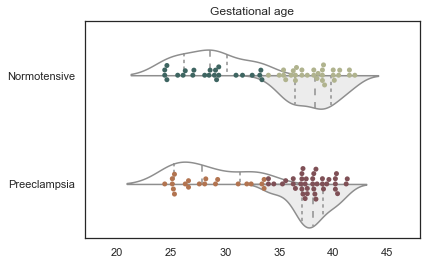

In [29]:
test_df['GesAgeBin'] = np.where((test_df['GA']>=34) , 1, 0)
test_df['PE_names'] = np.where((test_df['PE_binary']==0) , "Normotensive", "Preeclampsia")
test_df.sort_values(by='PE_names', ascending=True, inplace=True)

plt.rcParams['text.usetex'] = False

colors1 = ["white", "#ECECEC"]
colors = ['#3e6561', '#b0b38e', '#7f5056','#b27450']

plt.figure()
plot = sns.violinplot(data=test_df, x="GA", y="PE_names", hue="GesAgeBin", fill=True,
                       split=True, scale="count", scale_hue=False, palette=colors1, inner="quartile", 
                      orient="h")
plot = sns.swarmplot(x="GA", y="PE_names", data=test_df, palette=colors,hue="PE_onset_uniform") # color=".2", size = 3.5)

plt.xlabel('')
plt.xlim(17, 48)
plt.ylabel('')
plt.title('Gestational age')
plt.legend().remove()

plt.savefig("output_final/figure1/Demographics_GA_20250707.pdf", format="pdf", bbox_inches="tight")

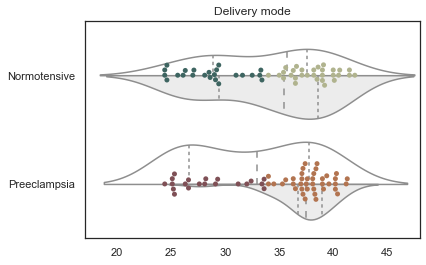

In [30]:
test_df['GesAgeBin'] = np.where((test_df['GA']>=34) , 1, 0)
test_df['PE_names'] = np.where((test_df['PE_binary']==0) , "Normotensive", "Preeclampsia")
test_df.sort_values(by='PE_names', ascending=True, inplace=True)

plt.rcParams['text.usetex'] = False

colors1 = ["white", "#ECECEC"]
colors = ['#3e6561', '#b0b38e', '#7f5056','#b27450']

plt.figure()
plot = sns.violinplot(data=test_df, x="GA", y="PE_names", hue="itpt_delivery_mode", fill=True,
                       split=True, scale="count", scale_hue=False, palette=colors1, inner="quartile", 
                      orient="h")
plot = sns.swarmplot(x="GA", y="PE_names", data=test_df, palette=colors,hue="PE_onset_uniform") # color=".2", size = 3.5)

plt.xlabel('')

plt.xlim(17, 48)
plt.ylabel('')
plt.title('Delivery mode')
plt.legend().remove()

plt.savefig("output_final/figure1/Demographics_Delivery_mode_20250707.pdf", format="pdf", bbox_inches="tight")

## Figure 1A, ED 1B (Chi-squared):

In [31]:
from tableone import TableOne, load_dataset

In [32]:
test_df['SGA_binary'] = test_df['calculated_iugr.x'].map({0: 'Normal', 1: 'SGA'}).astype(str)

# columns to summarize
columns = ["GA", 'age_delivery.x', "Fetal_sex_binary", 
           "SGA_binary",'itpt_delivery_mode', 
           "Path_binary", "HypoxiaScoreBuffa",
           "eTMB", "Path_MVM_binary"]

# columns containing categorical variables
categorical = ["Fetal_sex_binary","Path_binary","SGA_binary",'itpt_delivery_mode',"Path_MVM_binary"]
# non-normal variables
nonnormal = ["gest_age.x", "HypoxiaScoreBuffa","eTMB"]

# limit the binary variable "death" to a single row
limit = {"Fetal_sex_binary": 1,
        'Path_binary': 1,
       'SGA_binary': 1,
       'itpt_delivery_mode': 1}


# alternative labels
labels={'GA_binary': 'Gestational age at delivery',
       'Fetal_sex_binary': 'Fetal sex',
       'Path_binary': "Placental lesion",
       'SGA_binary': "Small for gestational age",
       'itpt_delivery_mode': "Mode of delivery",
       'age_delivery.x': "Maternal age at delivery",
        'gest_age.x': 'Gestational age at delivery',
        "HypoxiaScoreBuffa": 'Hypoxia score (Buffa)',
        "eTMB": "eMB"
       }

# set decimal places for age to 0
decimals = {"HypoxiaScoreBuffa": 1,
          "eTMB" :3 }

# optionally, a categorical variable for stratification
groupby = "PE_binary"

# display minimum and maximum for listed variables
#min_max = ['age_delivery.x']

table2 = TableOne(test_df, columns=columns, categorical=categorical, groupby=groupby,
                  nonnormal=nonnormal,label_suffix=True,pval = True, smd=False, pval_adjust="bonferroni",
                  htest_name=True, rename=labels, decimals=decimals, limit=limit) #,
                   #min_max=min_max)

# Save to Excel
fn1 = 'output_final/figure1/Demographics_Table_stats_PE_20250708.xlsx'
table2.to_excel(fn1)

# Save table to HTML
fn3 = 'output_final/figure1/Demographics_Table_stats_PE_20250708.html'
table2.to_html(fn3)

table2

Grouped by PE_binary                                                                                                     
                                                          Missing              Overall                  0.0                  1.0 P-Value (adjusted)               Test
n                                                                                  112                   53                   59                                      
GA, mean (SD)                                                   0           34.4 (5.2)           34.0 (5.4)           34.7 (5.1)              1.000  Two Sample T-test
Maternal age at delivery, mean (SD)                             0           31.1 (6.1)           31.4 (5.6)           30.8 (6.5)              1.000  Two Sample T-test
Fetal sex, n (%)                      1.0                                    62 (55.4)            29 (54.7)            33 (55.9)              1.000        Chi-squared
Small for gestational age, n (%)      Normal                                 67 (59.8)           53 (100.0)            14 (23.7)             <0.001        Chi-squared
Mode of delivery, n (%)               2.0                                    60 (53.6)            33 (62.3)            27 (45.8)              1.000        Chi-squared
Placental lesion, n (%)               1.0                                    75 (67.0)            32 (60.4)            43 (72.9)              1.000        Chi-squared
Hypoxia score (Buffa), median [Q1,Q3]                           0     0.0 [-12.0,10.5]      0.0 [-12.0,4.0]      4.0 [-7.0,15.0]              0.171     Kruskal-Wallis
eMB, median [Q1,Q3]                                             0  2.022 [1.719,2.385]  1.951 [1.651,2.389]  2.087 [1.890,2.380]              0.586     Kruskal-Wallis
Path_MVM_binary, n (%)                0                                      74 (66.1)            43 (81.1)            31 (52.5)              0.025        Chi-squared
                                      1                                      38 (33.9)            10 (18.9)            28 (47.5)

In [33]:
test_df['SGA_binary'] = test_df['calculated_iugr.x'].map({0: 'Normal', 1: 'SGA'}).astype(str)

# columns to summarize
columns = ["GA", 'age_delivery.x', "Fetal_sex_binary", 
           "SGA_binary",'itpt_delivery_mode', 
           "Path_binary", "HypoxiaScoreBuffa",
           "eTMB", "Path_MVM_binary"]

# columns containing categorical variables
categorical = ["Fetal_sex_binary","Path_binary","SGA_binary",'itpt_delivery_mode',"Path_MVM_binary"]
# non-normal variables
nonnormal = ["gest_age.x", "HypoxiaScoreBuffa","eTMB"]

# limit the binary variable "death" to a single row
limit = {"Fetal_sex_binary": 1,
        'Path_binary': 1,
       'SGA_binary': 1,
       'itpt_delivery_mode': 1}


# alternative labels
labels={'GA_binary': 'Gestational age at delivery',
       'Fetal_sex_binary': 'Fetal sex',
       'Path_binary': "Placental lesion",
       'SGA_binary': "Small for gestational age",
       'itpt_delivery_mode': "Mode of delivery",
       'age_delivery.x': "Maternal age at delivery",
        'gest_age.x': 'Gestational age at delivery',
        "HypoxiaScoreBuffa": 'Hypoxia score (Buffa)',
        "eTMB": "eMB"
       }

# set decimal places for age to 0
decimals = {"HypoxiaScoreBuffa": 1,
          "eTMB" :3 }

# optionally, a categorical variable for stratification
groupby = "Path_MVM_binary"

# display minimum and maximum for listed variables
#min_max = ['age_delivery.x']

table2 = TableOne(test_df, columns=columns, categorical=categorical, groupby=groupby,
                  nonnormal=nonnormal,label_suffix=True,pval = True, smd=False, pval_adjust="bonferroni",
                  htest_name=True, rename=labels, decimals=decimals, limit=limit) #,
                   #min_max=min_max)

# Save to Excel
fn1 = 'output_final/figure1/Demographics_Table_stats_MVM_20250708.xlsx'
table2.to_excel(fn1)

# Save table to HTML
fn3 = 'output_final/figure1/Demographics_Table_stats_MVM_20250708.html'
table2.to_html(fn3)

table2

Grouped by Path_MVM_binary                                                                                                     
                                                                Missing              Overall                    0                    1 P-Value (adjusted)               Test
n                                                                                        112                   74                   38                                      
GA, mean (SD)                                                         0           34.4 (5.2)           35.5 (5.3)           32.2 (4.3)              0.006  Two Sample T-test
Maternal age at delivery, mean (SD)                                   0           31.1 (6.1)           31.8 (5.8)           29.7 (6.5)              0.840  Two Sample T-test
Fetal sex, n (%)                      1.0                                          62 (55.4)            44 (59.5)            18 (47.4)              1.000        Chi-squared
Small for gestational age, n (%)      Normal                                       67 (59.8)            56 (75.7)            11 (28.9)             <0.001        Chi-squared
Mode of delivery, n (%)               2.0                                          60 (53.6)            45 (60.8)            15 (39.5)              0.467        Chi-squared
Placental lesion, n (%)               1.0                                          75 (67.0)            37 (50.0)           38 (100.0)             <0.001        Chi-squared
Hypoxia score (Buffa), median [Q1,Q3]                                 0     0.0 [-12.0,10.5]     0.0 [-12.0,10.0]      2.0 [-9.5,11.0]              1.000     Kruskal-Wallis
eMB, median [Q1,Q3]                                                   0  2.022 [1.719,2.385]  1.951 [1.661,2.382]  2.106 [1.965,2.482]              0.372     Kruskal-Wallis
Path_MVM_binary, n (%)                0                                            74 (66.1)           74 (100.0)                                  <0.001        Chi-squared
                                      1                                            38 (33.9)                                38 (100.0)

## Figure 1B (Variant counts)

In [34]:
# library(ggbreak) 
# library(patchwork)
# library(ggplot2)
# var_sum <- read.csv("/Users/kfisch/Dropbox/Research/UCSD/faculty/manuscripts/Fisch_placental_variants_PE/Figures/Final_figures/input/Somatic_variant_summary_20250722.csv",stringsAsFactors=FALSE)
# var_sum_sub <- subset(var_sum, !Variant.Class %in% c("total", "nGenes"))
# var_sum$Variant.Class <- as.character(var_sum$Variant.Class)
# var_sum$Variant.Class <- factor(var_sum$Variant.Class, levels=c("Total",
# "Missense",
# "Frame Shift Insertion",
# "Frame Shift Deletion",
# "In Frame Deletion",
# "In Frame Insertion",                                            
# "Nonsense",
# "Nonstop",
# "Unique Genes","Recurrent Genes (>2 placentas)"))

# ggplot(var_sum, aes(fill=Category, y=Count, x=Variant.Class)) +#, label = Count)) #+  geom_text(nudge_y = 100, angle=0) + 
#     geom_bar(position="dodge", stat="identity", alpha=9/10) +scale_fill_manual(values=c("#447273","#76B7BD")) +
#   coord_flip() + scale_y_break(c(250, 600), scales=1) + 
# theme_bw()+  theme(axis.text.x = element_text(face="bold", color="Black", 
#                         size=11, angle=0),
#           axis.text.y = element_text(face="bold", color="Black", 
#                            size=12, angle=0), legend.position="top", legend.title=element_blank(), legend.text=element_text(size=12,face="bold"),
#                                                                             axis.title.x=element_blank(),axis.title.y=element_blank())
# pdf("Variant_class_summary_barplot_somatic_20250722.pdf",onefile=FALSE)
# p<-ggplot(var_sum, aes(fill=Category, y=Count, x=Variant.Class)) +#, label = Count)) #+  geom_text(nudge_y = 100, angle=0) + 
#     geom_bar(position="dodge", stat="identity", alpha=9/10) +scale_fill_manual(values=c("#447273","#76B7BD")) +
#   coord_flip() + scale_y_break(c(250, 600), scales=1) + 
# theme_bw()+  theme(axis.text.x = element_text(face="bold", color="Black", 
#                            size=11, angle=0),
#           axis.text.y = element_text(face="bold", color="Black", 
#                            size=12, angle=0), legend.position="top", legend.title=element_blank(), legend.text=element_text(size=12,face="bold"),
#                                                                             axis.title.x=element_blank(),axis.title.y=element_blank())
# print(p)
# dev.off()

## Figure 1C (VAF):

In [35]:
test_df = df
samples =  pd.read_csv("inputs_new/Disc_cohort_SampleID.csv")["SampleID"]
maf = pd.read_csv("inputs_new/disc_20250721_maftools.maf", sep = "\t")

maf = maf[maf['Tumor_Sample_Barcode'].isin(samples)]
maf['vaf'] = maf['t_alt_count']/(maf['t_alt_count']+maf['t_ref_count'])

filtered_df = maf
filtered_df

,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Variant_Classification,Variant_Type,...,t_AD,n_AD,t_DP,n_DP,t_GQ,n_GQ,t_PL,n_PL,cohort,vaf
0,SH3D21,79729,.,GRCh38,chr1,36320626,36320627,+,Frame_Shift_Ins,INS,...,"45,17",NaN,64,NaN,99,NaN,"359,0,1215",NaN,disc,0.274194
1,HSD3B2,3284,.,GRCh38,chr1,119422454,119422454,+,Missense_Mutation,SNP,...,"2,58",NaN,60,NaN,91,NaN,"2520,91,0",NaN,disc,0.966667
2,SH3BP5,9467,.,GRCh38,chr3,15256280,15256280,+,Missense_Mutation,SNP,...,"124,186",NaN,310,NaN,99,NaN,"4749,0,3158",NaN,disc,0.600000
3,GOLGB1,2804,.,GRCh38,chr3,121691766,121691766,+,Missense_Mutation,SNP,...,"53,68",NaN,121,NaN,99,NaN,"1784,0,1383",NaN,disc,0.561983
4,SLCO2A1,6578,.,GRCh38,chr3,134029726,134029726,+,Missense_Mutation,SNP,...,"34,38",NaN,72,NaN,99,NaN,"1188,0,1033",NaN,disc,0.527778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5623,TUBA1C,84790,.,GRCh38,chr12,49265184,49265185,+,Frame_Shift_Ins,INS,...,"3,117",NaN,120,NaN,99,NaN,"5121,226,0",NaN,disc,0.975000
5624,TMEM100,55273,.,GRCh38,chr17,55720774,55720775,+,Frame_Shift_Ins,INS,...,"46,21",NaN,67,NaN,99,NaN,"398,0,1198",NaN,disc,0.313433
5625,PSG4,5672,.,GRCh38,chr19,43194588,43194588,+,Missense_Mutation,SNP,...,"350,234",NaN,584,NaN,99,NaN,"5225,0,11621",NaN,disc,0.400685
5626,FBLN1,2192,.,GRCh38,chr22,45542276,45542276,+,Missense_Mutation,SNP,...,"24,38",NaN,62,NaN,99,NaN,"1443,0,627",NaN,disc,0.612903


In [36]:
filtered_df['Variant_Classification'].value_counts()

Variant_Classification
Missense_Mutation    3787
Frame_Shift_Ins       222
Nonsense_Mutation      44
In_Frame_Del           42
Frame_Shift_Del        20
In_Frame_Ins           14
Nonstop_Mutation        2
Name: count, dtype: int64

In [37]:
bins = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] # Custom bin edges
labels = ["0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9"]
binned_data = pd.cut(filtered_df['vaf'], bins=bins, labels=labels)
print(pd.cut(filtered_df['vaf'], bins=bins).value_counts())
print(filtered_df['vaf'].describe())

vaf
(0.5, 0.6]    1349
(0.4, 0.5]    1339
(0.3, 0.4]     450
(0.6, 0.7]     309
(0.2, 0.3]     305
(0.9, 1.0]     189
(0.7, 0.8]      68
(0.1, 0.2]      62
(0.8, 0.9]      60
Name: count, dtype: int64
count    4131.000000
mean        0.504893
std         0.156062
min         0.179191
25%         0.426230
50%         0.497110
75%         0.563380
max         0.999487
Name: vaf, dtype: float64


In [38]:
plot_df = pd.Series(binned_data.value_counts(), name='count').sort_index().reset_index()
# new_row = pd.DataFrame({'vaf': [1.0], 'count': [0]})
# plot_df = pd.concat([plot_df, new_row], ignore_index=True)

plot_df['vaf'] = plot_df['vaf'].cat.add_categories(['1.0'])

new_row = pd.DataFrame({'vaf': ['1.0'], 'count': [0]})

plot_df = pd.concat([plot_df, new_row], ignore_index=True)
plot_df

,vaf,count
0,0.1,62
1,0.2,305
2,0.3,450
3,0.4,1339
4,0.5,1349
5,0.6,309
6,0.7,68
7,0.8,60
8,0.9,189
9,1.0,0


In [39]:
sns.set_theme(context='notebook', style='white', 
              font = 'arial', font_scale = 1)

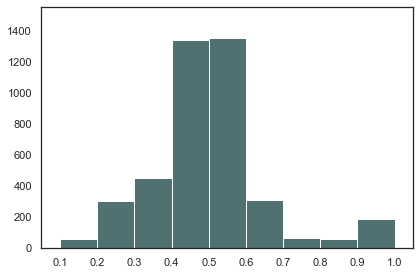

In [40]:
# Plot with bar width = 1
plt.bar(plot_df['vaf'], plot_df['count'], width=1, align='edge', color = "#4F7172")

plt.tight_layout()
plt.xlim(-0.5, 9.5)
plt.ylim(0, 1550)

plt.savefig("output_final/figure1/VAF_rare_variants_20250707.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Figure and Extended Data Figure 2

## Figure 2A and Extended Data Figure 2B (Boxplots):

In [41]:
# for spine in ax.spines.values():
#     spine.set_color((0, 0, 0, 1.0))
#     spine.set_linewidth(1)

# ax.tick_params(colors='black', width=1)
# ax.xaxis.label.set_color('black')
# ax.yaxis.label.set_color('black')

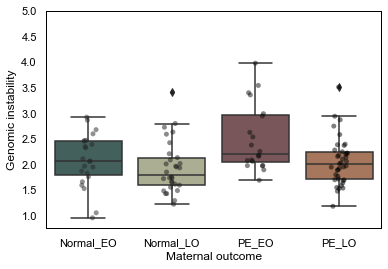

In [42]:
test_df = df[df['variant_cohort'] == 'discovery']
sns.set_style("white") 
colors = ['#3e6561', '#b0b38e', '#7f5056','#b27450']

ax =sns.boxplot(x = 'PE_onset_uniform', y = "eTMB", data = test_df, 
                order=["Normal_EO", "Normal_LO", "PE_EO", "PE_LO"],
                boxprops={'alpha': 1}, palette = colors)
sns.stripplot(data=test_df, x="PE_onset_uniform", y="eTMB",
              hue="PE_onset_uniform", hue_order=["Normal_EO", "Normal_LO", "PE_EO", "PE_LO"],
              order=["Normal_EO", "Normal_LO", "PE_EO", "PE_LO"], 
              dodge=False, ax=ax,palette='dark:black',alpha=0.5)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:4], labels[:4], title='PE_onset_uniform', bbox_to_anchor=(1, 1.02), loc='upper left')
plt.legend().remove()
plt.xlabel('Maternal outcome')
plt.ylabel('Genomic instability')
plt.ylim(0.75, 5.0)

for spine in ax.spines.values():
    spine.set_color((0, 0, 0, 1.0))
    spine.set_linewidth(1)

ax.tick_params(colors='black', width=1)
ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')

plt.savefig("output_final/figure2/Discovery_eMB.pdf", format="pdf", bbox_inches="tight")

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Normal_EO vs. Normal_LO: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.436e-01 U_stat=4.270e+02
Normal_LO vs. PE_EO: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.475e-04 U_stat=1.310e+02
PE_EO vs. PE_LO: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.046e-03 U_stat=5.560e+02
Normal_EO vs. PE_EO: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.595e-02 U_stat=1.510e+02
Normal_LO vs. PE_LO: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.733e-01 U_stat=4.720e+02
Normal_EO vs. PE_LO: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.214e-01 U_stat=4.930e+02


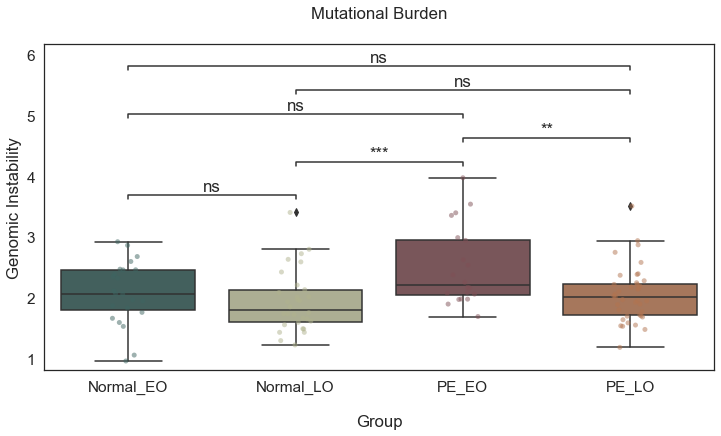

In [43]:
#define colors and orderings
PE_GA_names_palette = ['#3e6561', '#b0b38e', '#7f5056','#b27450']

PE_GA_names_order = ["Normal_EO", "Normal_LO", "PE_EO", "PE_LO"]
pairs = list(combinations(test_df['PE_onset_uniform'].unique(), 2))

plot_params = {
    'data': test_df,
    'x': 'PE_onset_uniform',
    'y': 'eTMB',
    'order': PE_GA_names_order,
    'palette': PE_GA_names_palette
}

with sns.plotting_context('notebook', font_scale=1.4):
    # Create new plot
    ax = get_log_ax()

    # Plot with seaborn
    sns.boxplot(ax=ax, **plot_params) 
    sns.stripplot(ax=ax, **plot_params,
              dodge=True,alpha=0.5)
    
    # Add annotations
    annotator = Annotator(ax, pairs, **plot_params)
    annotator.configure(test='Mann-Whitney',comparisons_correction="Benjamini-Hochberg").apply_and_annotate()

    # Label and show
    label_plot_for_PE_GA(ax)
    plt.show()

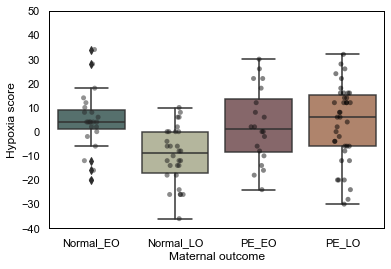

In [44]:
test_df = df[df['variant_cohort'] == 'discovery']
sns.set_style("white") 
colors = ['#3e6561', '#b0b38e', '#7f5056','#b27450']

ax =sns.boxplot(x = 'PE_onset_uniform', y = "HypoxiaScoreBuffa", data = test_df, 
                order=["Normal_EO", "Normal_LO", "PE_EO", "PE_LO"],
                boxprops={'alpha': 0.9}, palette = colors)
sns.stripplot(data=test_df, x="PE_onset_uniform", y="HypoxiaScoreBuffa",
              hue="PE_onset_uniform", hue_order=["Normal_EO", "Normal_LO", "PE_EO", "PE_LO"],
              order=["Normal_EO", "Normal_LO", "PE_EO", "PE_LO"], 
              dodge=False, ax=ax,palette='dark:black',alpha=0.5)

# remove extra legend handles
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:4], labels[:4], title='PE_onset_uniform', bbox_to_anchor=(1, 1.02), loc='upper left')
plt.legend().remove()
plt.xlabel('Maternal outcome')
plt.ylabel('Hypoxia score')
plt.ylim(-40, 50)

for spine in ax.spines.values():
    spine.set_color((0, 0, 0, 1.0))
    spine.set_linewidth(1)

ax.tick_params(colors='black', width=1)
ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')

plt.savefig("output_final/figure2/Discovery_HypoxiaScore.pdf", format="pdf", bbox_inches="tight")

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Normal_EO vs. Normal_LO: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.188e-04 U_stat=5.595e+02
Normal_LO vs. PE_EO: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.803e-03 U_stat=1.675e+02
PE_EO vs. PE_LO: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.243e-01 U_stat=3.675e+02
Normal_EO vs. PE_EO: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.420e-01 U_stat=2.620e+02
Normal_LO vs. PE_LO: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.658e-04 U_stat=2.905e+02
Normal_EO vs. PE_LO: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.244e-01 U_stat=4.415e+02


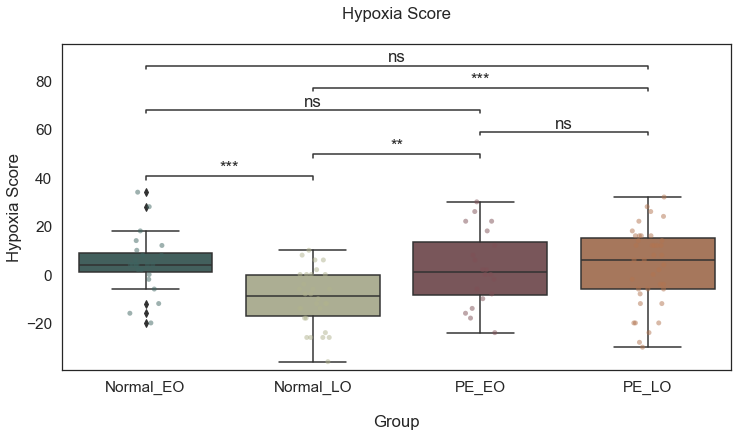

In [45]:
#define colors and orderings
PE_GA_names_palette = ['#3e6561', '#b0b38e', '#7f5056','#b27450']

PE_GA_names_order = ["Normal_EO", "Normal_LO", "PE_EO", "PE_LO"]
pairs = list(combinations(test_df['PE_onset_uniform'].unique(), 2))

plot_params = {
    'data': test_df,
    'x': 'PE_onset_uniform',
    'y': 'HypoxiaScoreBuffa',
    'order': PE_GA_names_order,
    'palette': PE_GA_names_palette
}

with sns.plotting_context('notebook', font_scale=1.4):
    # Create new plot
    ax = get_log_ax()

    # Plot with seaborn
    sns.boxplot(ax=ax, **plot_params) 
    sns.stripplot(ax=ax, **plot_params,
              dodge=True,alpha=0.5)
    
    # Add annotations
    annotator = Annotator(ax, pairs, **plot_params)
    annotator.configure(test='Mann-Whitney',comparisons_correction="Benjamini-Hochberg").apply_and_annotate()

    # Label and show
    label_plot_for_hyp(ax)
    plt.show()

## Figure 2C and Extended Data Figure 2C (CPH):

In [46]:
random_state = 123

In [47]:
test_df = df[df['variant_cohort'] == 'discovery']
df2_ddi = test_df.loc[:,["PE_binary", "eTMB", "HypoxiaScoreBuffa",
                        "GA", "age_delivery.x", "Fetal_sex_binary"]]

cph_models = [0, 0.01,  0.1]

for mod in cph_models:
    cph = CoxPHFitter(penalizer = mod)

    print(mod, ": ", np.mean(k_fold_cross_validation([cph], df2_ddi, duration_col = 'GA', 
                        event_col = "PE_binary", scoring_method="log_likelihood", seed = random_state)))

0 :  -1.1181181748200517
0.01 :  -1.1167981227711103
0.1 :  -1.110475765125018



   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.


[[<Axes: xlabel='rank-transformed time\n(p=0.1158)'>,
  <Axes: xlabel='km-transformed time\n(p=0.1986)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.1398)'>,
  <Axes: xlabel='km-transformed time\n(p=0.1354)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0692)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0624)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.5025)'>,
  <Axes: xlabel='km-transformed time\n(p=0.5582)'>]]

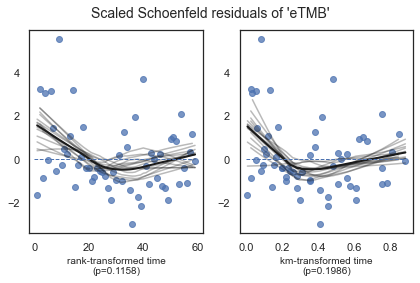

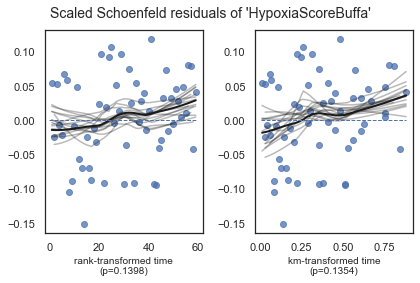

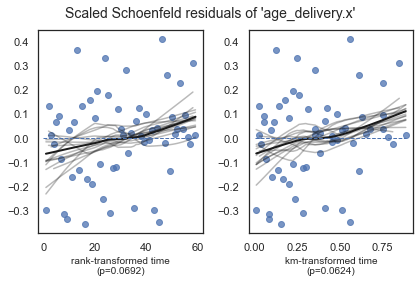

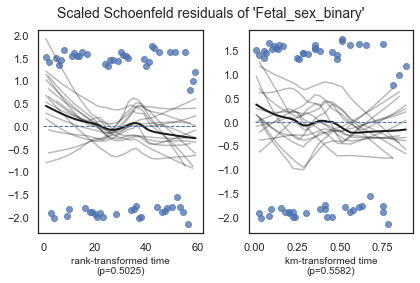

In [48]:
# check assumptions - passed all
cph = CoxPHFitter(penalizer = 0.1)

cph.fit(df2_ddi, duration_col = 'GA', event_col = "PE_binary")

cph.check_assumptions(df2_ddi, p_value_threshold=0.05, show_plots=True)

<lifelines.CoxPHFitter: fitted with 112 total observations, 53 right-censored observations>
             duration col = 'GA'
                event col = 'PE_binary'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 112
number of events observed = 59
   partial log-likelihood = -212.968
         time fit was run = 2025-08-21 02:52:57 UTC

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                           
eTMB               0.519     1.680     0.229           0.069           0.968               1.072               2.634
HypoxiaScoreBuffa  0.024     1.024     0.008           0.007           0.041               1.007               1.041
age_delivery.x    -0.011     0.989     0.022          -0.054           0.032               0.947               1.032
Fetal_sex_binary  -0.005     0.995     0.241          -0.478           0.467               0.620               1.596

                   cmp to      z     p  -log2(p)
covariate                                       
eTMB                0.000  2.262 0.024     5.400
HypoxiaScoreBuffa   0.000  2.845 0.004     7.815
age_delivery.x      0.000 -0.511 0.610     0.714
Fetal_sex_binary    0.000 -0.022 0.982     0.026
---
Concordance = 0.670
Partial AIC = 433.937
log-likelihood ratio test = 18.411 on 4 df
-log2(p) of ll-ratio test = 9.930

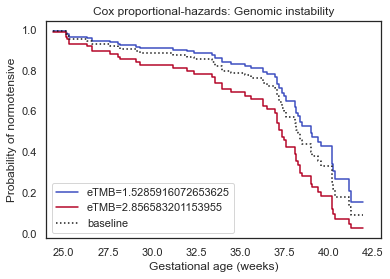

In [49]:
cph = CoxPHFitter(penalizer=0.1)
cph.fit(df2_ddi, duration_col = 'GA', event_col = "PE_binary")
cph.print_summary(decimals = 3)


cph.plot_partial_effects_on_outcome(covariates = 'eTMB', 
                                    values = [test_df['eTMB'].quantile(0.1), 
                                              test_df['eTMB'].quantile(0.9)], 
                                    cmap = 'coolwarm') 
plt.xlim(24, 43)
plt.xlabel('Gestational age (weeks)')
plt.ylabel('Probability of normotensive')
plt.title('Cox proportional-hazards: Genomic instability')
for spine in ax.spines.values():
    spine.set_color((0, 0, 0, 1.0))
    spine.set_linewidth(1)

ax.tick_params(colors='black', width=1)
ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')

name = f"output_final/figure2/Discovery_PE_binary_CPH_eTMB_20250707.pdf"
plt.savefig(name, format="pdf", bbox_inches="tight")

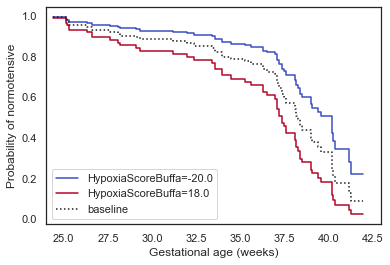

In [50]:
cph = CoxPHFitter(penalizer=0.1)
cph.fit(df2_ddi, duration_col = 'GA', event_col = "PE_binary")

cph.plot_partial_effects_on_outcome(covariates = 'HypoxiaScoreBuffa', 
                                    values = [test_df['HypoxiaScoreBuffa'].quantile(0.1), 
                                              test_df['HypoxiaScoreBuffa'].quantile(0.9)], 
                                    cmap = 'coolwarm') 
plt.xlim(24, 43)
plt.xlabel('Gestational age (weeks)')
plt.ylabel('Probability of normotensive')

name = f"output_final/figure2/Discovery_HypoxiaScoreBuffa_CPH_eTMB_20250707.pdf"
plt.savefig(name, format="pdf", bbox_inches="tight")

# Figure 3

## Figure 3A (CPH):

In [51]:
test_df = df[df['variant_cohort'] == 'discovery']
df2_ddi = test_df.loc[:,["Path_MVM_binary", "eTMB", "HypoxiaScoreBuffa",
                        "GA", "age_delivery.x", "Fetal_sex_binary"]]

cph_models = [0, 0.01, 0.1, 0.2]

for mod in cph_models:
    cph = CoxPHFitter(penalizer = mod)

    print(mod, ": ", np.mean(k_fold_cross_validation([cph], df2_ddi, duration_col = 'GA', 
                        event_col = "Path_MVM_binary", scoring_method="log_likelihood", seed = random_state)))

0 :  -0.8905917523437289
0.01 :  -0.8885953001704376
0.1 :  -0.8788281313074403
0.2 :  -0.8760954529455747



   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.


[[<Axes: xlabel='rank-transformed time\n(p=0.1980)'>,
  <Axes: xlabel='km-transformed time\n(p=0.1977)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.8328)'>,
  <Axes: xlabel='km-transformed time\n(p=0.7983)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.3849)'>,
  <Axes: xlabel='km-transformed time\n(p=0.3742)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.6175)'>,
  <Axes: xlabel='km-transformed time\n(p=0.6653)'>]]

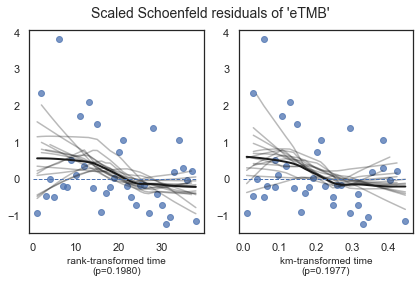

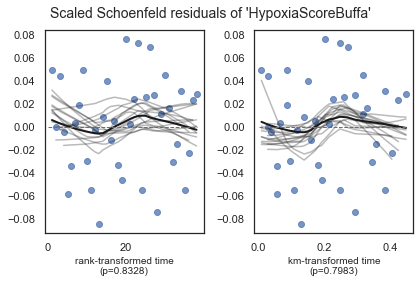

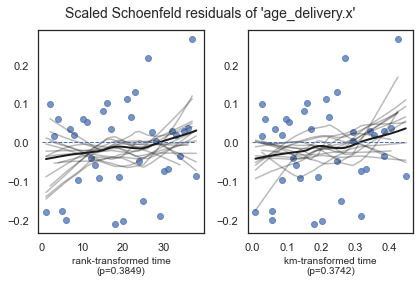

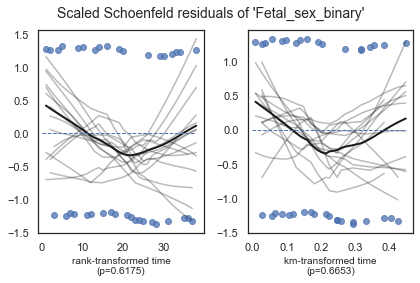

In [52]:
# check assumptions - passed all
cph = CoxPHFitter(penalizer = 0.2)

cph.fit(df2_ddi, duration_col = 'GA', event_col = "Path_MVM_binary")

cph.check_assumptions(df2_ddi, p_value_threshold=0.05, show_plots=True)

<lifelines.CoxPHFitter: fitted with 112 total observations, 74 right-censored observations>
             duration col = 'GA'
                event col = 'Path_MVM_binary'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 112
number of events observed = 38
   partial log-likelihood = -156.204
         time fit was run = 2025-08-21 02:53:14 UTC

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                           
eTMB               0.542     1.719     0.261           0.030           1.053               1.031               2.868
HypoxiaScoreBuffa  0.008     1.008     0.010          -0.011           0.027               0.989               1.028
age_delivery.x    -0.042     0.959     0.025          -0.090           0.006               0.914               1.006
Fetal_sex_binary  -0.247     0.781     0.285          -0.806           0.313               0.447               1.367

                   cmp to      z     p  -log2(p)
covariate                                       
eTMB                0.000  2.076 0.038     4.720
HypoxiaScoreBuffa   0.000  0.854 0.393     1.347
age_delivery.x      0.000 -1.711 0.087     3.523
Fetal_sex_binary    0.000 -0.865 0.387     1.369
---
Concordance = 0.684
Partial AIC = 320.408
log-likelihood ratio test = 9.856 on 4 df
-log2(p) of ll-ratio test = 4.542

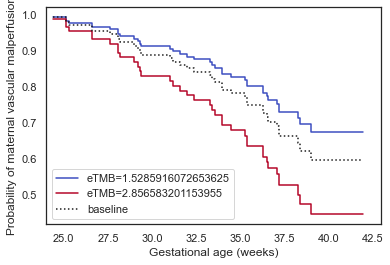

In [53]:
cph = CoxPHFitter(penalizer=0.1)
cph.fit(df2_ddi, duration_col = 'GA', event_col = "Path_MVM_binary")
cph.print_summary(decimals=3)


cph.plot_partial_effects_on_outcome(covariates = 'eTMB', 
                                    values = [test_df['eTMB'].quantile(0.1), 
                                              test_df['eTMB'].quantile(0.9)], 
                                    cmap = 'coolwarm') 
plt.xlim(24, 43)
plt.xlabel('Gestational age (weeks)')
plt.ylabel('Probability of maternal vascular malperfusion')

name = f"output_final/figure3/Discovery_MVM_binary_CPH_eTMB_20250707.pdf"
plt.savefig(name, format="pdf", bbox_inches="tight")

## Figure 3B (Boxplot):

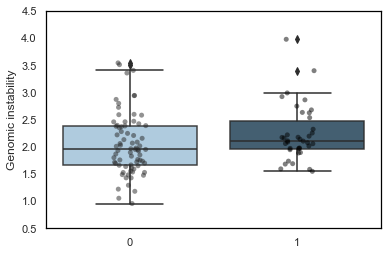

In [54]:
test_df = df[df['variant_cohort'] == 'discovery']

sns.set_style("white") 
colors = ['#9ec8e4','#284f6a'] 

plt.figure()  # Start a new figure for each plot

ax = sns.boxplot(x = "Path_MVM_binary", y = "eTMB", data = test_df, 
                boxprops={'alpha': 0.9}, palette = colors)
sns.stripplot(data=test_df, x="Path_MVM_binary", y="eTMB",
              dodge=True, ax = ax,palette='dark:black',alpha=0.5)
plt.ylim(0.5, 4.5)
plt.ylabel("Genomic instability")
plt.xlabel("")
for spine in ax.spines.values():
    spine.set_color('black')

plt.savefig("output_final/figure3/3B_Discovery_eTMB_MVM_boxplot.pdf", format="pdf", bbox_inches="tight")

In [55]:
var = "Path_MVM_binary"
Yes = test_df.loc[(test_df[var] == 1), "eTMB"].values
No = test_df.loc[(test_df[var]  == 0), "eTMB"].values

stat_results = [mannwhitneyu(Yes, No, alternative="greater")]
print("MW:", stat_results[0])

MW: MannwhitneyuResult(statistic=1738.0, pvalue=0.020816503624832724)


# Figure 4:

## Figure 4A (CPH):

In [56]:
test_df = df[df['variant_cohort'] == 'discovery']
df2_ddi = test_df.loc[:,["calculated_iugr.x", "eTMB", "HypoxiaScoreBuffa", "age_delivery.x",
                        "GA",  "Fetal_sex_binary"]]

cph_models = [0, 0.01, 0.1]

for mod in cph_models:
    cph = CoxPHFitter(penalizer = mod)

    print(mod, ": ", np.mean(k_fold_cross_validation([cph], df2_ddi, duration_col = 'GA', 
                        event_col = "calculated_iugr.x", scoring_method="log_likelihood", seed = random_state)))

0 :  -0.9093777301367714
0.01 :  -0.9078084849349326
0.1 :  -0.8999575406505403



   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 112 total observations, 67 right-censored observations>
         test_name = proportional_hazard_test

---
                        test_statistic    p  -log2(p)
Fetal_sex_binary  km              0.35 0.55      0.85
                  rank            0.47 0.49      1.02
HypoxiaScoreBuffa km              1.83 0.18      2.51
                  rank            1.67 0.20      2.35
age_delivery.x    km              4.85 0.03      5.18
                  rank            5.25 0.02      5.51
eTMB              km              1.94 0.16      2.61
                  rank            2.43 0.12      3.07



1. Variable 'age_delivery.x' failed the non-proportional test: p-value is 0.0220.

   Advice 1: the functional form of the variable 'age_delivery.x' might be incorrect. That is, there
may be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'age_delivery.x' using pd.cut, and then specify it in
`strata=['age_delivery.x', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readt

[[<Axes: xlabel='rank-transformed time\n(p=0.1188)'>,
  <Axes: xlabel='km-transformed time\n(p=0.1634)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.1957)'>,
  <Axes: xlabel='km-transformed time\n(p=0.1758)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0220)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0277)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.4920)'>,
  <Axes: xlabel='km-transformed time\n(p=0.5549)'>]]

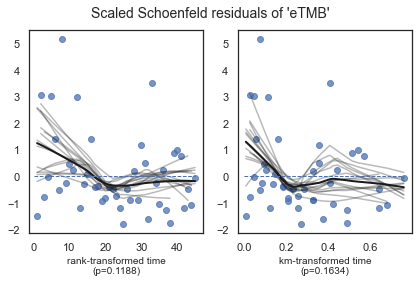

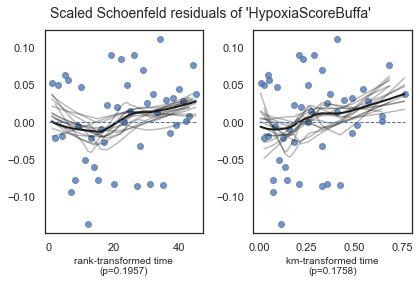

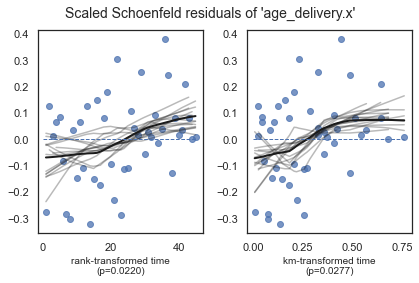

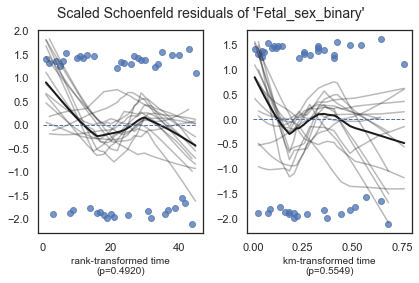

In [57]:
cph = CoxPHFitter(penalizer = 0.1)
cph.fit(df2_ddi, duration_col = 'GA', event_col = "calculated_iugr.x")
cph.check_assumptions(df2_ddi, p_value_threshold=0.05, show_plots=True)

In [58]:
df2_ddi['age**2'] = (df2_ddi['age_delivery.x'] - df2_ddi['age_delivery.x'].mean())**2
df2_ddi = df2_ddi.loc[:,["calculated_iugr.x", "eTMB", "HypoxiaScoreBuffa", "age**2",
                        "GA",  "Fetal_sex_binary"]]
df2_ddi.head()

,calculated_iugr.x,eTMB,HypoxiaScoreBuffa,age**2,GA,Fetal_sex_binary
55,0.0,1.526308,4.0,62.156330,27.1,1.0
72,0.0,1.659567,4.0,1.245615,24.4,0.0
71,0.0,2.458163,12.0,78.924187,27.0,1.0
70,0.0,2.863097,-16.0,8.317044,29.0,0.0
82,0.0,2.348366,14.0,83.102758,28.5,0.0



   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.


[[<Axes: xlabel='rank-transformed time\n(p=0.1268)'>,
  <Axes: xlabel='km-transformed time\n(p=0.1701)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.2463)'>,
  <Axes: xlabel='km-transformed time\n(p=0.2191)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.9113)'>,
  <Axes: xlabel='km-transformed time\n(p=0.9166)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.5071)'>,
  <Axes: xlabel='km-transformed time\n(p=0.5595)'>]]

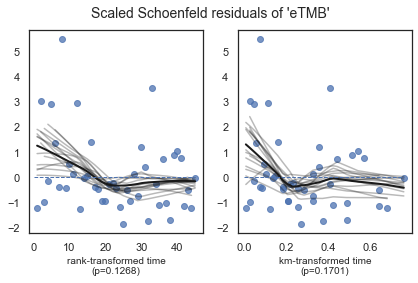

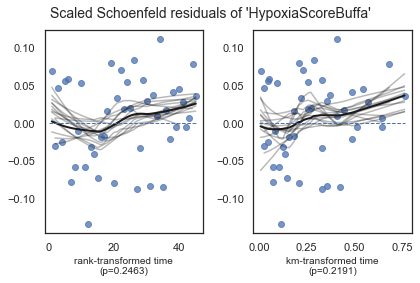

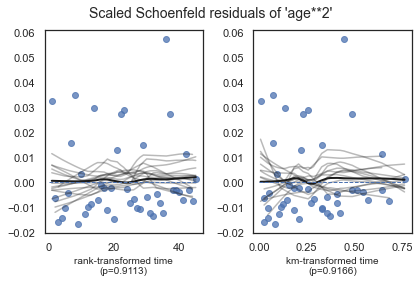

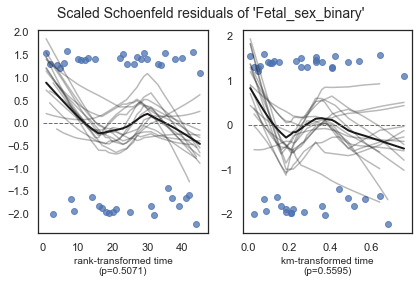

In [59]:
# check assumptions - passed all
cph = CoxPHFitter(penalizer = 0.1)
cph.fit(df2_ddi, duration_col = 'GA', event_col = "calculated_iugr.x")
# cph.fit(df2_ddi, duration_col = 'GA', event_col = "calculated_iugr.x", strata=['age_delivery.x'])

cph.check_assumptions(df2_ddi, p_value_threshold=0.05, show_plots=True)

<lifelines.CoxPHFitter: fitted with 112 total observations, 67 right-censored observations>
             duration col = 'GA'
                event col = 'calculated_iugr.x'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 112
number of events observed = 45
   partial log-likelihood = -167.114
         time fit was run = 2025-08-21 02:53:23 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                          
eTMB              0.532     1.702     0.257           0.028           1.035               1.028               2.816
HypoxiaScoreBuffa 0.023     1.023     0.009           0.005           0.041               1.005               1.042
age**2            0.004     1.004     0.003          -0.002           0.009               0.998               1.009
Fetal_sex_binary  0.093     1.098     0.270          -0.436           0.622               0.646               1.864

                   cmp to     z     p  -log2(p)
covariate                                      
eTMB                0.000 2.069 0.039     4.696
HypoxiaScoreBuffa   0.000 2.535 0.011     6.473
age**2              0.000 1.304 0.192     2.380
Fetal_sex_binary    0.000 0.345 0.730     0.453
---
Concordance = 0.674
Partial AIC = 342.229
log-likelihood ratio test = 14.603 on 4 df
-log2(p) of ll-ratio test = 7.480

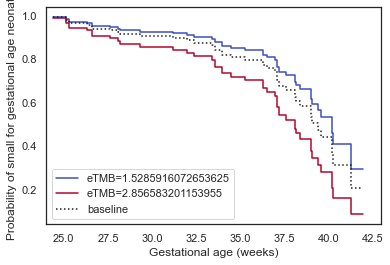

In [60]:
cph = CoxPHFitter(penalizer=0.1)
cph.fit(df2_ddi, duration_col = 'GA', event_col = "calculated_iugr.x")
cph.print_summary(decimals = 3)

cph.plot_partial_effects_on_outcome(covariates = 'eTMB', 
                                    values = [test_df['eTMB'].quantile(0.1), 
                                              test_df['eTMB'].quantile(0.9)], 
                                    cmap = 'coolwarm') 
plt.xlim(24, 43)
plt.xlabel('Gestational age (weeks)')
plt.ylabel('Probability of small for gestational age neonate')

name = f"output_final/figure4/Discovery_SGA_CPH_eMB_20250723.pdf"
plt.savefig(name, format="pdf", bbox_inches="tight")

## Figure 4B (Boxplot):

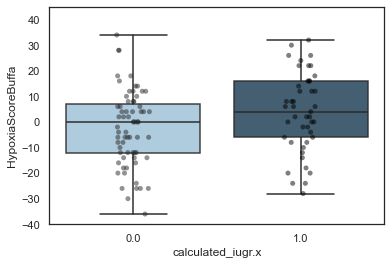

In [61]:
test_df = df[df['variant_cohort'] == 'discovery']

sns.set_style("white") 
colors = ['#9ec8e4','#284f6a'] 

plt.figure()  # Start a new figure for each plot

ax = sns.boxplot(x = "calculated_iugr.x", y = "HypoxiaScoreBuffa", data = test_df, 
                boxprops={'alpha': 0.9}, palette = colors)
sns.stripplot(data=test_df, x="calculated_iugr.x", y="HypoxiaScoreBuffa",
              dodge=True, ax = ax,palette='dark:black',alpha=0.5)
plt.ylim(-40, 45)

plt.savefig("output_final/figure4/Discovery_Hypoxia_Score_SGA.pdf", format="pdf", bbox_inches="tight")

In [62]:
var = "calculated_iugr.x"
Yes = test_df.loc[(test_df[var] == 1), "HypoxiaScoreBuffa"].values
No = test_df.loc[(test_df[var]  == 0), "HypoxiaScoreBuffa"].values

stat_results = [mannwhitneyu(Yes, No, alternative="greater")]
print("MW:", stat_results[0])

MW: MannwhitneyuResult(statistic=1855.0, pvalue=0.0196229584650291)
